In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.insert(0, '/home/mehdi/github/LSSutils')
from LSSutils.lab import radec2hpix, hpix2radec, overdensity

from sklearn.cluster import KMeans
import numpy as np

import matplotlib.pyplot as plt

camb is not installed!


In [3]:
from LSSutils.utils import shiftra

In [4]:
def r2radec(r):
    #x:0, y:1, z:2    
    rad2deg = 180./np.pi
    dec = rad2deg*np.arcsin(r[:, 2])
    ra = rad2deg*np.arctan(r[:, 1]/r[:, 0])
    ra[r[:, 0]<0] += 180. 
    return ra, dec

def radec2r(ra, dec):
    '''
    inputs
    --------
    ra and dec in deg
    
    retuns
    --------
    r in `distance`
    
    notes:
    x = cos(phi)sin(theta) or cos(ra)cos(dec)
    y = sin(phi)sin(theta) or sin(ra)cos(dec)
    z = cos(theta) or sin(dec)
    '''     
    ra_rad, dec_rad = np.deg2rad(ra), np.deg2rad(dec)
    x = np.cos(dec_rad)*np.cos(ra_rad)
    y = np.cos(dec_rad)*np.sin(ra_rad)
    z = np.sin(dec_rad)        
    r = np.column_stack([x, y, z])      
    return r

In [5]:
class SphericalKMeans(KMeans):
    
    def __init__(self, n_clusters=40, random_state=42, **kwargs):        
        
        super().__init__(n_clusters=n_clusters, 
                         random_state=random_state,
                         **kwargs)
        
    def fit_radec(self, ra, dec, sample_weight=None):          
        r = radec2r(ra, dec)
        self.fit(r, sample_weight=sample_weight)
        self.centers_radec = r2radec(self.cluster_centers_)
        
    def histogram(self, y):
        
        y_binned = []        
        for i in range(self.n_clusters):            
            indices = self.labels_ == i            
            y_binned.append(np.median(y[indices], axis=0))            
        return np.array(y_binned)

In [6]:
import healpy as hp

In [7]:
ngal = hp.read_map('/B/Shared/mehdi/eboss/data/v7_2/0.3/eBOSS_QSO_clustering_NGC_v7_2_0.3_tot.hp512.dat.fits')
nran = hp.read_map('/B/Shared/mehdi/eboss/data/v7_2/0.3/eBOSS_QSO_clustering_NGC_v7_2_0.3_tot.hp512.ran.fits')
mask = hp.read_map('/B/Shared/mehdi/eboss/data/v7_2/0.3/mask_NGC.hp512.ran.fits') > 0

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [8]:
ra, dec = hpix2radec(512, np.argwhere(mask).flatten())

In [9]:
delta = overdensity(ngal, nran, mask)[mask]

In [10]:
km = SphericalKMeans(n_jobs=6, n_clusters=10, tol=1.e-6)

In [11]:
km.fit_radec(ra, dec) #, sample_weight=nran[mask]/nran[mask].mean())

In [12]:
km.labels_.max()

9

Text(0, 0.5, 'DEC [deg]')

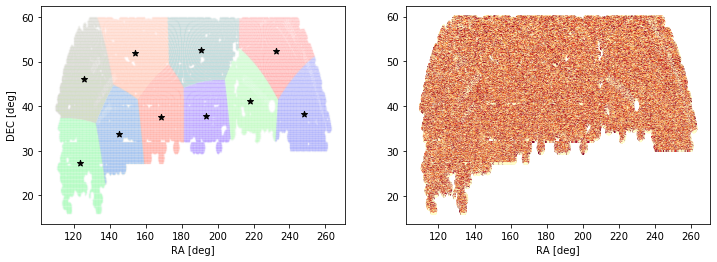

In [35]:
n_clusters = km.n_clusters
colors = [plt.cm.rainbow(i/(n_clusters-1)) for i in range(n_clusters)]


fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12, 4))


for i in range(n_clusters):
    mask_i = km.labels_ == i
    ax1.scatter(shiftra(ra[mask_i]),
                dec[mask_i], 
                s=1,
                color=colors[i],
                alpha=0.01)
# center    
ax1.scatter(shiftra(km.centers_radec[0]),
            km.centers_radec[1], 
            color='k',
            marker='*',
            s=40)

ax2.scatter(shiftra(ra),
            dec, 
            s=1,
            c=delta,
            cmap=plt.cm.YlOrRd,
            vmin=-1.,
            vmax=1.)

ax1.set_xlabel('RA [deg]')
ax2.set_xlabel('RA [deg]')
ax1.set_ylabel('DEC [deg]')

In [13]:
km.histogram(nran[mask])

array([54.94852448, 54.65642929, 54.92732811, 55.29935455, 53.94029999,
       54.19145584, 54.54433823, 55.36314774, 55.0160675 , 54.63772583])

In [14]:
y_binned = []        
for i in range(km.n_clusters):            
    indices = km.labels_ == i            
    y_binned.append(np.sum(nran[mask][indices]/nran[mask].mean(), axis=0))            
y_binned = np.array(y_binned)

In [15]:
dict(zip(np.arange(10), np.bincount(km.labels_)))

{0: 20961,
 1: 26086,
 2: 24388,
 3: 23141,
 4: 26455,
 5: 21659,
 6: 25104,
 7: 23883,
 8: 24367,
 9: 21789}

In [36]:
nran[mask]

array([3.75512648, 4.54891205, 4.54290819, ..., 3.64326   , 4.55947113,
       3.94946671])

In [16]:
km.cluster_centers_

array([[-0.76034241, -0.18003627,  0.61212631],
       [-0.28969513, -0.71656289,  0.62024381],
       [-0.67551621,  0.46722234,  0.5558273 ],
       [-0.58144606, -0.11147276,  0.7954108 ],
       [-0.48369987,  0.73092668,  0.45957916],
       [-0.58517162, -0.45568176,  0.65848041],
       [-0.39903981,  0.55172135,  0.72020215],
       [-0.54428445,  0.26191606,  0.78662443],
       [-0.76660144,  0.15323168,  0.61007597],
       [-0.36406937, -0.47183293,  0.79311846]])

In [17]:
r = radec2r(ra, dec)

In [18]:
rmin, rmax = r.min(axis=0), r.max(axis=0)
rmin, rmax

(array([-0.8744238 , -0.85394778,  0.27473958]),
 array([-0.09636972,  0.87305718,  0.86651611]))

In [19]:
dist = (r[:, np.newaxis] - km.cluster_centers_)
sq_dist = dist*dist
sq_dist.shape

(237833, 10, 3)

In [20]:
sq_dist_tot = sq_dist.sum(axis=2)

In [24]:
distances = list()
for i in range(sq_dist_tot.shape[0]):
    distances.append((i, sq_dist_tot[i, :]))

In [25]:
indices[...] = True
indices

array([ True,  True,  True, ...,  True,  True,  True])

In [26]:
num_neighbors = indices.size // 10
labels = np.zeros(indices.size)*np.nan

for ic in range(10):    
    
    print('.', end=' ')
    
    i = 0
    num_sample = 0
    distances.sort(key = lambda tup: tup[1][ic])
    
    while(num_sample <= num_neighbors): 
        ix = distances[i][0]
        if indices[ix]:
            labels[ix] = ic
            indices[ix] = False
            num_sample += 1
        i += 1   
        if i == (indices.size - 1):
            print('all pixels are assigned')
            break
            
    #if i == (indices.size - 1):
    #    print('all pixels are assigned')
    #    break

. . . . . . . . . . all pixels are assigned


1275634.9923277497
1278976.399026394
1282151.3479314446
1295536.6827837825
1261927.1354951859
1249285.9781182408
1261882.7829689384
1304661.6472709775
1263851.4689881802
1225584.9296717346


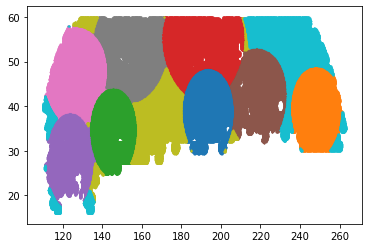

In [29]:
for i in range(10):
    print(nran[mask][labels == i].sum())
    plt.scatter(ra[labels == i], dec[labels==i], 1)

In [27]:
np.isnan(labels).sum()

1

In [71]:
np.array_equal(sq_dist_tot.argmin(axis=1), km.labels_)

True

In [110]:
el_sq_dist_tot = np.column_stack([np.arange(sq_dist_tot.shape[0]), sq_dist_tot])

In [112]:
d = np.zeros(10, dtype=[('a', 'i8'), ('b', 'f8')])

In [114]:
d['a'] = np.arange(10)

In [115]:
d['b'] = np.random.normal(size=10)

In [117]:
np.sort(d, order='b')

array([(3, -2.38673254), (1, -1.42455691), (7, -0.62159623),
       (9, -0.09451726), (4,  0.07797692), (0,  0.1427499 ),
       (5,  0.64364208), (8,  0.81740616), (6,  1.01078416),
       (2,  1.29441383)], dtype=[('a', '<i8'), ('b', '<f8')])

In [118]:
d

array([(0,  0.1427499 ), (1, -1.42455691), (2,  1.29441383),
       (3, -2.38673254), (4,  0.07797692), (5,  0.64364208),
       (6,  1.01078416), (7, -0.62159623), (8,  0.81740616),
       (9, -0.09451726)], dtype=[('a', '<i8'), ('b', '<f8')])

In [111]:
el_sq_dist_tot.sort()

array([[0.00000000e+00, 5.89459928e-01, 1.28405237e+00, ...,
        7.63607938e-02, 3.27752196e-01, 7.49567066e-01],
       [1.00000000e+00, 5.86048524e-01, 1.28078373e+00, ...,
        7.51062101e-02, 3.25329860e-01, 7.46761864e-01],
       [2.00000000e+00, 5.82645073e-01, 1.27750631e+00, ...,
        7.38644428e-02, 3.22921644e-01, 7.43953441e-01],
       ...,
       [2.37830000e+05, 8.79492908e-01, 2.24264905e+00, ...,
        4.61142893e-01, 4.10284874e-01, 1.71236188e+00],
       [2.37831000e+05, 8.75536798e-01, 2.23847613e+00, ...,
        4.59918592e-01, 4.07673292e-01, 1.70888121e+00],
       [2.37832000e+05, 8.67646451e-01, 2.23011348e+00, ...,
        4.57500821e-01, 4.02485179e-01, 1.70191537e+00]])

In [120]:
sq_dist_tot[]

array([[0.58945993, 1.28405237, 0.23443498, ..., 0.07636079, 0.3277522 ,
        0.74956707],
       [0.58604852, 1.28078373, 0.23330986, ..., 0.07510621, 0.32532986,
        0.74676186],
       [0.58264507, 1.27750631, 0.23220322, ..., 0.07386444, 0.32292164,
        0.74395344],
       ...,
       [0.87949291, 2.24264905, 0.12878718, ..., 0.46114289, 0.41028487,
        1.71236188],
       [0.8755368 , 2.23847613, 0.12785249, ..., 0.45991859, 0.40767329,
        1.70888121],
       [0.86764645, 2.23011348, 0.12602689, ..., 0.45750082, 0.40248518,
        1.70191537]])

In [77]:
dist_np = np.zeros(sq_dist_tot.shape[0], dtype=np.dtype([('ix', 'i8'), 
                                                        ('dist', 'f8', 10)]))

In [105]:
dist_np['ix'] = np.arange(sq_dist_tot.shape[0])
dist_np['dist'] = sq_dist_tot

In [123]:
sq_dist_tot_s = np.sort(dist_np, order='dist', axis=0)

In [124]:
sq_dist_tot_s

array([(222565, [0.38442196, 1.56191469, 0.02331278, 0.43696621, 0.18626598, 0.84638683, 0.23345293, 0.18989557, 0.09455713, 1.08341311]),
       ( 49513, [0.05326937, 0.39341521, 0.49177822, 0.00746388, 0.96932693, 0.08269426, 0.59927374, 0.2109192 , 0.17634215, 0.13277088]),
       ( 45637, [0.2241566 , 0.99414632, 0.12026014, 0.11212952, 0.37186558, 0.47637719, 0.14482673, 0.00282359, 0.06947741, 0.52993841]),
       ...,
       ( 73761, [0.47546776, 1.41971654, 0.06103724, 0.32356443, 0.1560526 , 0.83101428, 0.02238594, 0.03909961, 0.17079431, 0.87218677]),
       ( 33152, [0.34803447, 1.14362114, 0.11470333, 0.18798048, 0.29249641, 0.62185835, 0.07409628, 0.00480203, 0.13324644, 0.63852779]),
       (230689, [0.99509279, 2.28372505, 0.13872231, 0.92525875, 0.00542473, 1.55551644, 0.16015732, 0.40173617, 0.48065928, 1.6992271 ])],
      dtype=[('ix', '<i8'), ('dist', '<f8', (10,))])

In [102]:
sq_dist_tot_s['dist'][:, 0]

array([0.38442196, 0.05326937, 0.2241566 , ..., 0.47546776, 0.34803447,
       0.99509279])

In [87]:
sq_dist_tot_s['dist'][:, 0]

array([0.38442196, 0.05326937, 0.2241566 , ..., 0.47546776, 0.34803447,
       0.99509279])

In [88]:
sq_dist_tot_s['dist'][:, -1]

array([1.08341311, 0.13277088, 0.52993841, ..., 0.87218677, 0.63852779,
       1.6992271 ])

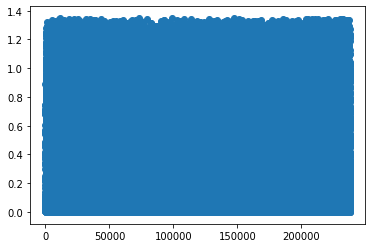

In [92]:
plt.scatter(np.arange(sq_dist_tot_s.size), sq_dist_tot_s['dist'][:, 0])